In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import zipfile
import io
import os
import time

In [2]:
def load_data_from_directory(data_directory):
    all_data = []
    all_labels = []
    num_subjects = 40
    num_images_per_subject = 10
    
    for subject in range(1, num_subjects + 1):
        subject_dir = os.path.join(data_directory, "s{}".format(subject))
        for image in range(1, num_images_per_subject + 1):
            img_path = os.path.join(subject_dir, "{}.bmp".format(image))
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                all_data.append(img)
                all_labels.append(subject)

    all_data = np.array(all_data)
    all_labels = np.array(all_labels)

    return all_data, all_labels

# Feature Extraction

### Pearson correlation coeficient

In [3]:
def pearson_corr (data, y, n):
    correlation_matrix = np.corrcoef(data.T, y)
    correlations = correlation_matrix[:-1, -1]
    selected_indices = sorted(range(len(correlations)), key=lambda k: abs(correlations[k]), reverse=True)[:n]
    corr_data = pca_data[:, selected_indices]
    return corr_data

### Mutual Information

In [58]:
def mutual_inf(data, y, n):
    mutual_info_scores = mutual_info_classif(data, y)
    selected_indices = np.argsort(mutual_info_scores)[-n:]
    mutual_inf_data = pca_data[:, selected_indices]
    return mutual_inf_data

# Classifiers

##  Self Written Classifiers

### KNN

In [5]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def self_knn(X_train, X_test, y_train, k):
        final_output = []
        for i in range(len(X_test)):
            d = []
            votes = []
            for j in range(len(X_train)):
                dist = euclidean_distance(X_train[j] , X_test[i])
                d.append([dist, j])
            d.sort()
            d = d[0:k]
            for s,j in d:
                votes.append(y_train[j])
                
            ans = Counter(votes).most_common(1)[0][0]
            final_output.append(ans)       
        return final_output

### Parzen Window

In [6]:
def parzen_window_classification(X_train, X_test, y_train, bandwidth):
    kde_models = []

    for label in np.unique(y_train):
        class_points = X_train[y_train == label]
        kde = KernelDensity(bandwidth=bandwidth)
        kde.fit(class_points)
        kde_models.append((label, kde))

    predictions = []

    for x_test in X_test:
        class_scores = []
        for label, kde in kde_models:
            score = np.exp(kde.score_samples([x_test]))  # Using log likelihood, so applying exp
            class_scores.append((label, score))

        predicted_label = max(class_scores, key=lambda x: x[1])[0]
        predictions.append(predicted_label)

    return np.array(predictions)

### Naive Bayes

In [7]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_probs = None
        self.feature_probs = None

    def fit(self, X, y):
        # Calculate class probabilities
        unique_classes, class_counts = np.unique(y, return_counts=True)
        self.class_probs = dict(zip(unique_classes, class_counts / len(y)))

        # Calculate feature probabilities for each class
        self.feature_probs = {}
        for label in unique_classes:
            class_indices = (y == label)
            class_data = X[class_indices]
            self.feature_probs[label] = {
                'mean': np.mean(class_data, axis=0),
                'std': np.std(class_data, axis=0) + 1e-8  # Add a small value to avoid division by zero
            }

    def predict(self, X):
        predictions = []
        for x in X:
            class_scores = {}
            for label, class_prob in self.class_probs.items():
                feature_probs = self.feature_probs[label]
                log_likelihood = np.sum(-0.5 * ((x - feature_probs['mean']) / feature_probs['std'])**2 - np.log(feature_probs['std'] * np.sqrt(2 * np.pi)))
                class_scores[label] = np.log(class_prob) + log_likelihood

            predicted_label = max(class_scores, key=class_scores.get)
            predictions.append(predicted_label)

        return np.array(predictions)
    
    

def NaiveBayes(X_train, X_test, y_train):
    nb_classifier = NaiveBayesClassifier()
    nb_classifier.fit(X_train, y_train)
    prediction = nb_classifier.predict(X_test)
    return prediction

## python functions

In [8]:
def knn(x_train, x_test, y_train, k):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    return y_pred

def bayes(x_train, x_test, y_train):
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_test)
    return y_pred

def decision_tree(X_train, X_test, y_train):
    clf = DecisionTreeClassifier(random_state=0)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def random_forest(X_train, X_test, y_train):
    clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

## Choose Parameter

In [9]:
def choose_self_k(X_train, X_test, y_train, y_test, n, plot):
    acc = np.zeros((n,1))

    for k in range(n):
        y_pred = self_knn(X_train, X_test, y_train, k+1)
        acc[k] = accuracy_score(y_test, y_pred)
    if(plot):
        plt.plot(range(1,n+1),acc)
        plt.xlabel("k")
        plt.ylabel("Accuracy")
    best_k = np.argmax(acc)+1
    return best_k

def choose_k(X_train, X_test, y_train, y_test, n, plot):
    acc = np.zeros((n,1))

    for k in range(n):
        y_pred = knn(X_train, X_test, y_train, k+1)
        acc[k] = accuracy_score(y_test, y_pred)
    if(plot):    
        plt.plot(range(1,n+1),acc)
        plt.xlabel("k")
        plt.ylabel("Accuracy")
    best_k = np.argmax(acc)+1
    return best_k

def choose_bandwidth(X_train, X_test, y_train, y_test, b_min, b_max, counter):
    accuracy = []
    print("\nPlease wait, Calculating the best bandwidth!")
    for i in range(b_min,b_max):
        if(counter and i%10==0):
            print(i)
        bandwidth = i
        predictions = parzen_window_classification(X_train, X_test, y_train, bandwidth)
        accuracy.append(accuracy_score(y_test, predictions))
    best_bandwidth = np.argmax(accuracy) + b_min
    return best_bandwidth

# Classification

### with mutual information feature extraction

In [10]:
def classify_mutual(X_train_mutual, X_test_mutual, y_train, self_k_mutual, k_mutual, Bandwidth_mutual):
    # Classification
    print("Start Classification")
    # Self KNN
    self_knn_m = self_knn(X_train_mutual, X_test_mutual, y_train, self_k_mutual)

    # Python KNN
    knn_m = knn(X_train_mutual, X_test_mutual, y_train, k_mutual)

    # Parzen Window
    parzen_m = parzen_window_classification(X_train_mutual, X_test_mutual, y_train, Bandwidth_mutual)

    # Naive Bayes
    naive_bayes_m = NaiveBayes(X_train_mutual, X_test_mutual, y_train)

    # Bayes
    bayes_m = bayes(X_train_mutual, X_test_mutual, y_train)

    # Decision Tree
    DT_m = decision_tree(X_train_mutual, X_test_mutual, y_train)

    # Random Forest
    RF_m = random_forest(X_train_mutual, X_test_mutual, y_train)
    print("End Classification\n")
    
    # Accuracy
    print("Start calculating accuray")
    acc_self_knn_m, acc_knn_m, acc_parzen_m, acc_naive_bayes_m, acc_bayes_m, acc_DT_m, acc_RF_m = accuracy_mutual(self_knn_m, knn_m, parzen_m, naive_bayes_m, bayes_m, DT_m, RF_m)
    print("End calculating accuray\n")
    
    return acc_self_knn_m, acc_knn_m, acc_parzen_m, acc_naive_bayes_m, acc_bayes_m, acc_DT_m, acc_RF_m

### with Pearson Correlation feature extraction

In [11]:
def classify_corr(X_train_corr, X_test_corr, y_train, self_k_corr, k_corr, Bandwidth_corr):
    # Classification
    print("Start Classification")
    # Self KNN
    self_knn_c = self_knn(X_train_corr, X_test_corr, y_train, self_k_corr)

    # Python KNN
    knn_c = knn(X_train_corr, X_test_corr, y_train, k_corr)

    # Parzen Window
    parzen_c = parzen_window_classification(X_train_corr, X_test_corr, y_train, Bandwidth_corr)

    # Naive Bayes
    naive_bayes_c = NaiveBayes(X_train_corr, X_test_corr, y_train)

    # Bayes
    bayes_c = bayes(X_train_corr, X_test_corr, y_train)

    # Decision Tree
    DT_c = decision_tree(X_train_corr, X_test_corr, y_train)

    # Random Forest
    RF_c = random_forest(X_train_corr, X_test_corr, y_train)
    print("End Classification\n")
    
    # Accuracy
    print("Start calculating accuray")
    acc_self_knn_c, acc_knn_c, acc_parzen_c, acc_naive_bayes_c, acc_bayes_c, acc_DT_c, acc_RF_c = accuracy_corr(self_knn_c, knn_c, parzen_c, naive_bayes_c, bayes_c, DT_c, RF_c)
    print("End calculating accuray\n")
    return acc_self_knn_c, acc_knn_c, acc_parzen_c, acc_naive_bayes_c, acc_bayes_c, acc_DT_c, acc_RF_c

# Accuracy

### For data with mutual information feature extraction

In [12]:
def accuracy_mutual(self_knn_mutual, knn_mutual, parzen_mutual, naive_bayes_mutual, bayes_mutual, decision_tree_mutual, random_forest_mutual):
    # Self KNN
    acc_self_knn_mutual = accuracy_score(y_test, self_knn_mutual)
    print("Accuracy of self knn: {:.2f}%".format(acc_self_knn_mutual * 100))

    # Python KNN
    acc_knn_mutual = accuracy_score(y_test, knn_mutual)
    print("Accuracy of Python Func. knn: {:.2f}%".format(acc_knn_mutual * 100))

    # Parzen Window
    acc_parzen_mutual = accuracy_score(y_test, parzen_mutual)
    print("Accuracy of Parzen Window: {:.2f}%".format(acc_parzen_mutual * 100))

    # Naive Bayes
    acc_naive_bayes_mutual = accuracy_score(y_test, naive_bayes_mutual)
    print("Accuracy of Naive Bayes: {:.2f}%".format(acc_naive_bayes_mutual * 100))

    # Bayes
    acc_bayes_mutual = accuracy_score(y_test, bayes_mutual)
    print("Accuracy of Bayes: {:.2f}%".format(acc_bayes_mutual * 100))

    # Decision Tree
    acc_DT_mutual = accuracy_score(y_test, decision_tree_mutual)
    print("Accuracy of Decision Tree: {:.2f}%".format(acc_DT_mutual * 100))

    # Random Forest
    acc_RF_mutual = accuracy_score(y_test, random_forest_mutual)
    print("Accuracy of Random Forest: {:.2f}%".format(acc_RF_mutual * 100))
    
    return acc_self_knn_mutual, acc_knn_mutual, acc_parzen_mutual, acc_naive_bayes_mutual, acc_bayes_mutual, acc_DT_mutual, acc_RF_mutual

### For data with Pearson Correlation feature extraction

In [13]:
def accuracy_corr(self_knn_corr, knn_corr, parzen_corr, naive_bayes_corr, bayes_corr, decision_tree_corr, random_forest_corr):
    # Self KNN
    acc_self_knn_corr = accuracy_score(y_test, self_knn_corr)
    print("Accuracy of self knn: {:.2f}%".format(acc_self_knn_corr * 100))

    # Python KNN
    acc_knn_corr = accuracy_score(y_test, knn_corr)
    print("Accuracy of Python Func. knn: {:.2f}%".format(acc_knn_corr * 100))

    # Parzen Window
    acc_parzen_corr = accuracy_score(y_test, parzen_corr)
    print("Accuracy of Parzen Window: {:.2f}%".format(acc_parzen_corr * 100))

    # Naive Bayes
    acc_naive_bayes_corr = accuracy_score(y_test, naive_bayes_corr)
    print("Accuracy of Naive Bayes: {:.2f}%".format(acc_naive_bayes_corr * 100))

    # Bayes
    acc_bayes_corr = accuracy_score(y_test, bayes_corr)
    print("Accuracy of Bayes: {:.2f}%".format(acc_bayes_corr * 100))

    # Decision Tree
    acc_DT_corr = accuracy_score(y_test, decision_tree_corr)
    print("Accuracy of Decision Tree: {:.2f}%".format(acc_DT_corr * 100))

    # Random Forest
    acc_RF_corr = accuracy_score(y_test, random_forest_corr)
    print("Accuracy of Random Forest: {:.2f}%".format(acc_RF_corr * 100))

    return acc_self_knn_corr, acc_knn_corr, acc_parzen_corr, acc_naive_bayes_corr, acc_bayes_corr, acc_DT_corr, acc_RF_corr

# Implementation

In [14]:
# Load data
data_path = "/Users/parniantaheri/Desktop/temp/class/term 7/یادگیری در مغز و ماشین ۱/HW/HW2/ORL"
data, labels = load_data_from_directory(data_path)
flattend_data = data.flatten()

In [15]:
# flat data
flattend_data = []
for i in range(400):
    flattend_data.append(data[i].flatten())

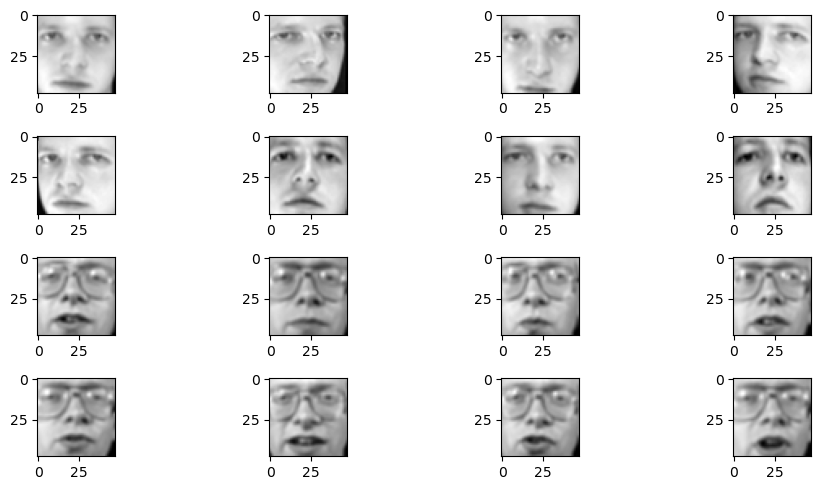

In [16]:
#plot
n = 4
fig, axs = plt.subplots(n, n, figsize=(10, 5))
for i in range(n):
    for j in range(n):
        axs[i, j].imshow(data[5*i + j], cmap='gray')
plt.tight_layout()
plt.show()

### PCA 

In [41]:
num_features = 50
pca = PCA(n_components=num_features)
pca_data = pca.fit_transform(flattend_data)
print(pca_data.shape)

(400, 50)


### Feature Extraction

In [42]:
num_features_after_selection = 10

In [43]:
corr_data = pearson_corr(pca_data, labels, num_features_after_selection)
mutual_inf_data = mutual_inf(pca_data, labels, num_features_after_selection)

### Split data

In [44]:
#Train - Test split
n = num_features_after_selection
m = 200
X_train_mutual = np.zeros((m,n))
X_test_mutual = np.zeros((m,n))
X_train_corr = np.zeros((m,n))
X_test_corr = np.zeros((m,n))
X_train_pca = np.zeros((m,num_features))
X_test_pca = np.zeros((m,num_features))
y_train = np.zeros(m)
y_test = np.zeros(m)
    
for i in range(int(m/5)):
    X_train_mutual[5*i:5*i+5] = mutual_inf_data[10*i:10*i+5, :]
    X_test_mutual[5*i:5*i+5] = mutual_inf_data[10*i+5:10*i+10, :]
    X_train_corr[5*i:5*i+5] = corr_data[10*i:10*i+5, :]
    X_test_corr[5*i:5*i+5] = corr_data[10*i+5:10*i+10, :]
    X_train_pca[5*i:5*i+5] = pca_data[10*i:10*i+5, :]
    X_test_pca[5*i:5*i+5] = pca_data[10*i+5:10*i+10, :]
    y_train[5*i:5*i+5] = labels[10*i:10*i+5]
    y_test[5*i:5*i+5] = labels[10*i+5:10*i+10]

### Choose The Best Param.

The best self_k in mutual information feature is:  1
The best self_k in Pearson Correlation feature is:  1


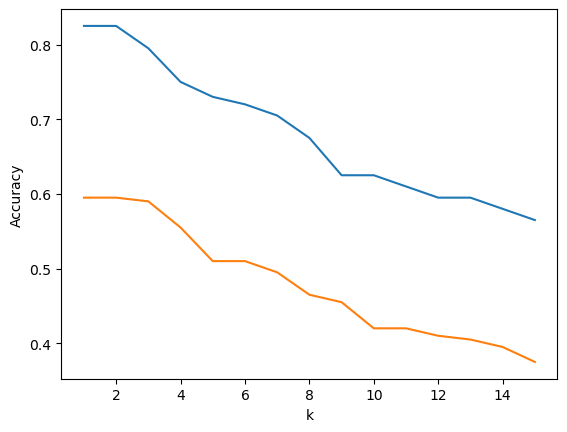

In [28]:
# K in self written KNN
n = 15
self_k_mutual = choose_self_k(X_train_mutual, X_test_mutual, y_train, y_test, n, plot=1)
print("The best self_k in mutual information feature is: ", self_k_mutual)

self_k_corr = choose_self_k(X_train_corr, X_test_corr, y_train, y_test, n, plot=1)
print("The best self_k in Pearson Correlation feature is: ", self_k_corr)

The best k in mutual information feature is:  1
The best k in Pearson Correlation feature is:  1


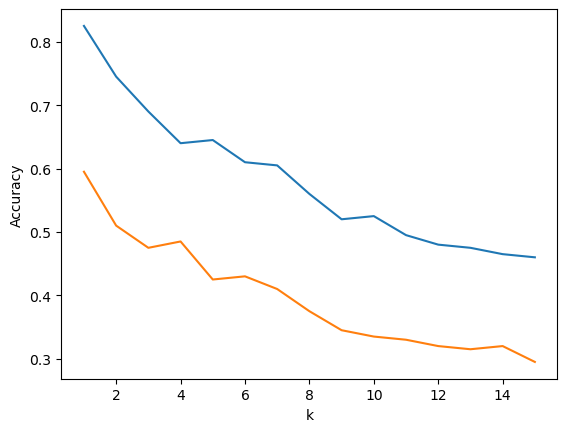

In [29]:
# K in KNN
n = 15
k_mutual = choose_k(X_train_mutual, X_test_mutual, y_train, y_test, n, 1)
print("The best k in mutual information feature is: ", k_mutual)

k_corr = choose_k(X_train_corr, X_test_corr, y_train, y_test, n, 1)
print("The best k in Pearson Correlation feature is: ", k_corr)

In [30]:
# Bandwidth in Parzen window

# for mutual
Bandwidth_mutual = choose_bandwidth(X_train_mutual, X_test_mutual, y_train, y_test, 1, 200, 1)
print("The best bandwith in mutual information feature is: ", Bandwidth_mutual)

# for correlation
Bandwidth_corr = choose_bandwidth(X_train_corr, X_test_corr, y_train, y_test, 1, 200, 1)
print("The best bandwith in Pearson Correlation feature is: ", Bandwidth_corr)


Please wait, Calculating the best bandwidth!
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
The best bandwith in mutual information feature is:  21

Please wait, Calculating the best bandwidth!
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
The best bandwith in Pearson Correlation feature is:  117


### Classification

In [31]:
acc_main_m = classify_mutual(X_train_mutual, X_test_mutual, y_train, self_k_mutual, k_mutual, Bandwidth_mutual)
acc_main_c = classify_corr(X_train_corr, X_test_corr, y_train, self_k_corr, k_corr, Bandwidth_corr)

Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 82.50%
Accuracy of Python Func. knn: 82.50%
Accuracy of Parzen Window: 82.50%
Accuracy of Naive Bayes: 69.50%
Accuracy of Bayes: 69.50%
Accuracy of Decision Tree: 43.00%
Accuracy of Random Forest: 78.50%
End calculating accuray

Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 59.50%
Accuracy of Python Func. knn: 59.50%
Accuracy of Parzen Window: 62.00%
Accuracy of Naive Bayes: 51.00%
Accuracy of Bayes: 51.00%
Accuracy of Decision Tree: 27.00%
Accuracy of Random Forest: 56.00%
End calculating accuray



# Extra Works

### The Effect of PCA Components

In [63]:
pca_min = 30
pca_max = 71
step = 5
n = num_features_after_selection
m = 200
X_train_m = np.zeros((m,n))
X_test_m = np.zeros((m,n))
X_train_c = np.zeros((m,n))
X_test_c = np.zeros((m,n))
y_train = np.zeros(m)
y_test = np.zeros(m)

acc_m = []
acc_c = []
acc_p = []
t = []
for l in range(pca_min, pca_max+1, step):
    start_time = time.time()
    print(l, "PCA component!")
    #pca
    print("Start dimension reduction using pca")
    num_features = l
    pca = PCA(n_components = num_features)
    pca_data2 = pca.fit_transform(flattend_data)
    X_train_p = np.zeros((m,num_features))
    X_test_p = np.zeros((m,num_features))
    print("End dimension reduction using pca\n")
    
    # feature extraction
    print("Start feature extraction")
    corr_data = pearson_corr(pca_data2, labels, num_features_after_selection)
    mutual_inf_data = mutual_inf(pca_data2, labels, num_features_after_selection)\
    print("End feature extraction\n")
    
    # split data
    for i in range(int(m/5)):
        X_train_m[5*i:5*i+5] = mutual_inf_data[10*i:10*i+5, :]
        X_test_m[5*i:5*i+5] = mutual_inf_data[10*i+5:10*i+10, :]
        X_train_c[5*i:5*i+5] = corr_data[10*i:10*i+5, :]
        X_test_c[5*i:5*i+5] = corr_data[10*i+5:10*i+10, :]
        X_train_p[5*i:5*i+5] = pca_data2[10*i:10*i+5, :]
        X_test_p[5*i:5*i+5] = pca_data2[10*i+5:10*i+10, :]
        y_train[5*i:5*i+5] = labels[10*i:10*i+5]
        y_test[5*i:5*i+5] = labels[10*i+5:10*i+10]
        
    # Choose params
    print("Start choosing the best parameter")
    # k in self knn
    print("K = ", 1, "For all of the components")
    
    # Bandwidth in Parzen window
    #if l == pca_min:
    Bandwidth_m = choose_bandwidth(X_train_m, X_test_m, y_train, y_test, 1, 50, 0)
    print("The best bandwith in mutual information feature for", l,"components is: ", Bandwidth_m)
#      #   print("Bandwidth_m is equal for all the componenets")
    Bandwidth_c = choose_bandwidth(X_train_c, X_test_c, y_train, y_test, 100, 200, 0)
    print("The best bandwith in Pearson Correlation feature for", l,"components is: ", Bandwidth_c)

    Bandwidth_p = Bandwidth_c # found out by  several classifying
    
    # Classification and Accuracy
    x = classify_mutual(X_train_m, X_test_m, y_train, 1, 1, Bandwidth_m)
    acc_m.append(x)
       

    x =  classify_corr(X_train_c, X_test_c, y_train, 1, 1, Bandwidth_c)
    acc_c.append(x)
    
    x =  classify_corr(X_train_p, X_test_p, y_train, 1, 1, Bandwidth_p)
    acc_p.append(x)
    
    stop_time = time.time()
    t.append(stop_time-start_time)

30 PCA component!
Start dimension reduction using pca
End dimension reduction using pca

Start feature extraction
End feature extraction

Start choosing the best parameter
K =  1 For all of the components
(200, 10)
Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 82.50%
Accuracy of Python Func. knn: 82.50%
Accuracy of Parzen Window: 82.50%
Accuracy of Naive Bayes: 69.50%
Accuracy of Bayes: 69.50%
Accuracy of Decision Tree: 42.50%
Accuracy of Random Forest: 76.50%
End calculating accuray

Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 58.50%
Accuracy of Python Func. knn: 58.50%
Accuracy of Parzen Window: 59.00%
Accuracy of Naive Bayes: 49.00%
Accuracy of Bayes: 49.00%
Accuracy of Decision Tree: 27.00%
Accuracy of Random Forest: 54.50%
End calculating accuray

Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 86.50%
Accuracy of Python Func. knn: 86.50%
Accuracy of Parz

End feature extraction

Start choosing the best parameter
K =  1 For all of the components
(200, 10)
Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 82.50%
Accuracy of Python Func. knn: 82.50%
Accuracy of Parzen Window: 82.50%
Accuracy of Naive Bayes: 69.50%
Accuracy of Bayes: 69.50%
Accuracy of Decision Tree: 42.50%
Accuracy of Random Forest: 76.50%
End calculating accuray

Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 58.50%
Accuracy of Python Func. knn: 58.50%
Accuracy of Parzen Window: 59.00%
Accuracy of Naive Bayes: 49.00%
Accuracy of Bayes: 49.00%
Accuracy of Decision Tree: 27.00%
Accuracy of Random Forest: 54.50%
End calculating accuray

Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 87.00%
Accuracy of Python Func. knn: 87.00%
Accuracy of Parzen Window: 87.00%
Accuracy of Naive Bayes: 63.50%
Accuracy of Bayes: 63.50%
Accuracy of Decision Tree: 39.50%
Accu

Text(0.5, 1.0, 'Time of classification in different pca components')

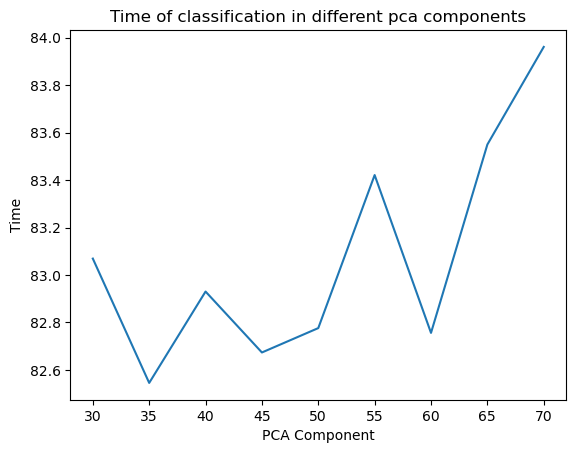

In [33]:
plt.plot(range(pca_min, pca_max+1, step),t)
plt.xlabel("PCA Component")
plt.ylabel("Time")
plt.title("Time of classification in different pca components")

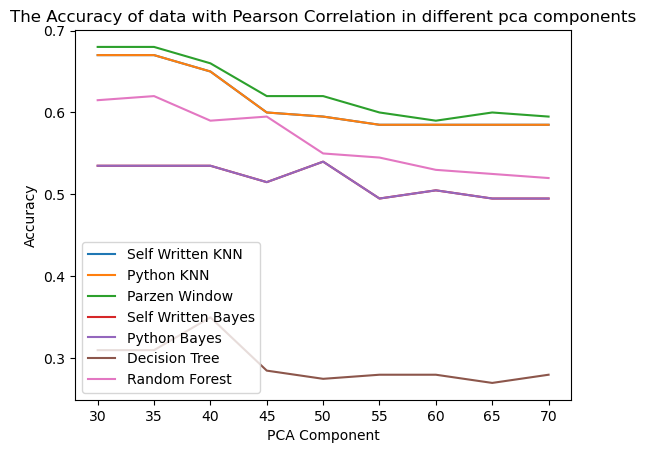

In [34]:
plt.plot(range(pca_min, pca_max+1, step),acc_c)
plt.xlabel("PCA Component")
plt.ylabel("Accuracy")
plt.title("The Accuracy of data with Pearson Correlation in different pca components")
plt.legend(["Self Written KNN","Python KNN", "Parzen Window", "Self Written Bayes", "Python Bayes", "Decision Tree", "Random Forest"])

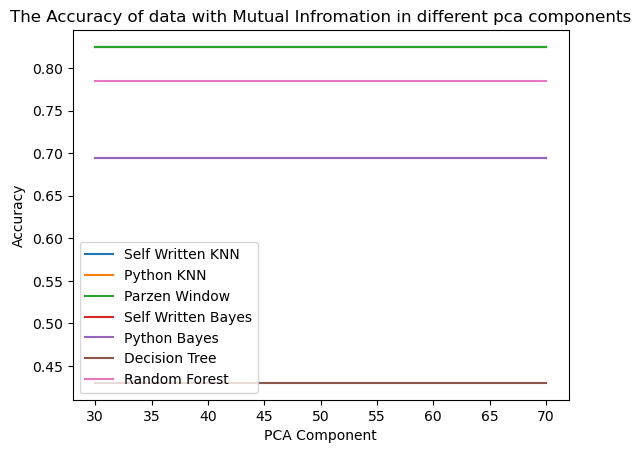

In [35]:
plt.plot(range(pca_min, pca_max+1, step),acc_m)
plt.xlabel("PCA Component")
plt.ylabel("Accuracy")
plt.title("The Accuracy of data with Mutual Infromation in different pca components")
plt.legend(["Self Written KNN","Python KNN", "Parzen Window", "Self Written Bayes", "Python Bayes", "Decision Tree", "Random Forest"])

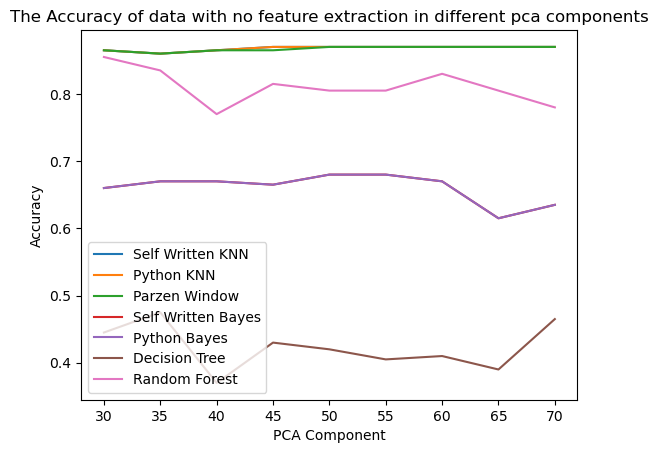

In [36]:
plt.plot(range(pca_min, pca_max+1, step),acc_p)
plt.xlabel("PCA Component")
plt.ylabel("Accuracy")
plt.title("The Accuracy of data with no feature extraction in different pca components")
plt.legend(["Self Written KNN","Python KNN", "Parzen Window", "Self Written Bayes", "Python Bayes", "Decision Tree", "Random Forest"])

### The Effect of Different Size of Training Set 

In [32]:
s = np.arange(1,10)
p = 10-s
#Train - Test split
v = num_features_after_selection
m = 200
acc_m2 = []
acc_c2 = []
for s in range(1,10,2):
    print("Size of Training set: ", s)
    p = 10 - s
    X_train_m = np.zeros((int(m/5*s),v))
    X_test_m = np.zeros((int(m/5*p),v))
    X_train_c = np.zeros((int(m/5*s),v))
    X_test_c = np.zeros((int(m/5*p),v))
    y_train = np.zeros(int(m/5*s))
    y_test = np.zeros(int(m/5*p))

    for i in range(40):
        X_train_m[s*i:s*i+s] = mutual_inf_data[10*i:10*i+s, :]
        X_test_m[p*i:p*i+p] = mutual_inf_data[10*i+s:10*i+10, :]
        X_train_c[s*i:s*i+s] = corr_data[10*i:10*i+s, :]
        X_test_c[p*i:p*i+p] = corr_data[10*i+s:10*i+10, :]
        y_train[s*i:s*i+s] = labels[10*i:10*i+s]
        y_test[p*i:p*i+p] = labels[10*i+s:10*i+10]
    
    # Choose params
    print("\n Start choosing the best parameter")
    # Bandwidth in Parzen window
    Bandwidth_m = choose_bandwidth(X_train_m, X_test_m, y_train, y_test, 1, 50, 0)
    print("The best bandwith in mutual information feature for", s,"image per person for training is: ", Bandwidth_m)
    print("Bandwidth_m is equal for all the componenets")
    Bandwidth_c = choose_bandwidth(X_train_c, X_test_c, y_train, y_test, 1, 200, 0)
    print("The best bandwith in Pearson Correlation feature for", s,"image per person for training is: ", Bandwidth_c)
    print("End choosing the best parameter\n")
    
    # Classification and Accuracy
    x = classify_mutual(X_train_m, X_test_m, y_train, 1, 1, Bandwidth_m)
    acc_m2.append(x)
       

    x =  classify_corr(X_train_c, X_test_c, y_train, 1, 1, Bandwidth_c)
    acc_c2.append(x)

Size of Training set:  1

 Start choosing the best parameter

Please wait, Calculating the best bandwidth!
10
20
30
40
The best bandwith in mutual information feature for 1 image per person for training is:  41
Bandwidth_m is equal for all the componenets

Please wait, Calculating the best bandwidth!
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
The best bandwith in Pearson Correlation feature for 1 image per person for training is:  23
End choosing the best parameter

Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 53.89%
Accuracy of Python Func. knn: 53.89%
Accuracy of Parzen Window: 53.89%
Accuracy of Naive Bayes: 53.89%
Accuracy of Bayes: 53.89%
Accuracy of Decision Tree: 16.39%
Accuracy of Random Forest: 42.78%
End calculating accuray

Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 36.39%
Accuracy of Python Func. knn: 36.39%
Accuracy of Parzen Window: 36.39%
Accuracy of Naive Ba

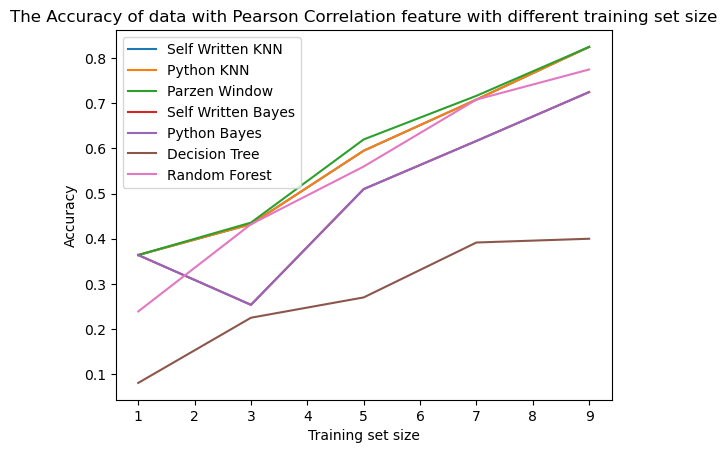

In [35]:
plt.plot(range(1, 10, 2),acc_c2)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("The Accuracy of data with Pearson Correlation feature with different training set size")
plt.legend(["Self Written KNN","Python KNN", "Parzen Window", "Self Written Bayes", "Python Bayes", "Decision Tree", "Random Forest"])

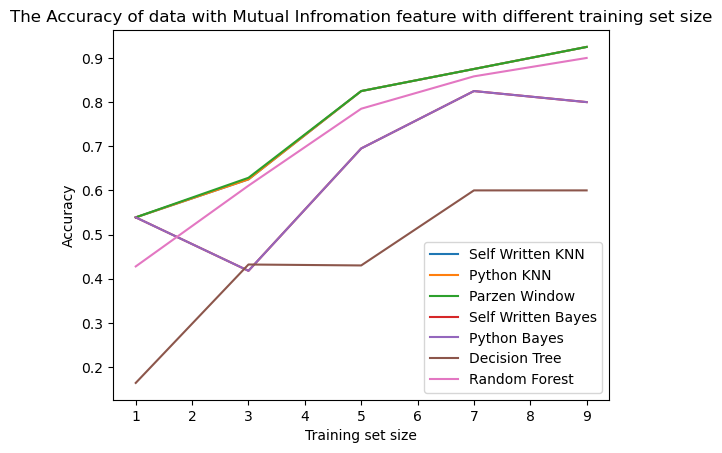

In [36]:
plt.plot(range(1, 10, 2),acc_m2)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("The Accuracy of data with Mutual Infromation feature with different training set size")
plt.legend(["Self Written KNN","Python KNN", "Parzen Window", "Self Written Bayes", "Python Bayes", "Decision Tree", "Random Forest"])

## Add noise

In [37]:
def add_salt_and_pepper_noise(image, noise_ratio):
    noisy_image = np.zeros(image.shape)
    for img in image:
        temp = img.copy()
        total_pixels = img.size
        num_salt = int(total_pixels * noise_ratio)
        salt_coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape]
        temp[salt_coords] = 255  # Set pixels to maximum value (salt)
        num_pepper = int(total_pixels * noise_ratio)
        pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape]
        temp[pepper_coords] = 0  # Set pixels to minimum value (pepper)
        noisy_image[i] = temp
    return noisy_image

In [45]:
noise_ratio = 0.1
n = num_features_after_selection
m = 200
X_test_noisy_m = np.zeros((m,n))
X_test_noisy_c = np.zeros((m,n))
X_train_noisy_m = np.zeros((m,n))
X_train_noisy_c = np.zeros((m,n))
flattend_data_noisy = add_salt_and_pepper_noise(np.array(flattend_data), noise_ratio)

##
num_features = 50
pca = PCA(n_components=num_features)
pca_data_noisy = pca.fit_transform(flattend_data_noisy)
##
X_noisy_corr = pearson_corr(pca_data_noisy, labels, num_features_after_selection)
X_noisy_mutual = mutual_inf(pca_data_noisy, labels, num_features_after_selection)
for i in range(40):
        X_train_noisy_m[5*i:5*i+5] = X_noisy_mutual[10*i:10*i+5, :]
        X_train_noisy_c[5*i:5*i+5] = X_noisy_corr[10*i:10*i+5, :]
        X_test_noisy_m[5*i:5*i+5] = X_noisy_mutual[10*i+5:10*i+10, :]
        X_test_noisy_c[5*i:5*i+5] = X_noisy_corr[10*i+5:10*i+10, :]

In [47]:

# Bandwidth in Parzen window

# for mutual
Bandwidth_mutual_noisy = choose_bandwidth(X_train_mutual, X_test_noisy_m, y_train, y_test, 1, 100, 0)
print("The best bandwith in mutual information feature is: ", Bandwidth_mutual_noisy)

# for correlation
Bandwidth_corr_noisy = choose_bandwidth(X_train_corr, X_test_noisy_c, y_train, y_test, 100, 200, 0)
print("The best bandwith in Pearson Correlation feature is: ", Bandwidth_corr_noisy)


Please wait, Calculating the best bandwidth!
The best bandwith in mutual information feature is:  14

Please wait, Calculating the best bandwidth!
The best bandwith in Pearson Correlation feature is:  160


In [48]:
acc_m_noisy = classify_mutual(X_train_mutual, X_test_noisy_m, y_train, 1, 1, Bandwidth_mutual_noisy)
acc_c_noisy = classify_corr(X_train_corr, X_test_noisy_c, y_train, 1, 1, Bandwidth_corr_noisy)

Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 2.50%
Accuracy of Python Func. knn: 2.50%
Accuracy of Parzen Window: 4.00%
Accuracy of Naive Bayes: 3.00%
Accuracy of Bayes: 3.00%
Accuracy of Decision Tree: 3.00%
Accuracy of Random Forest: 2.50%
End calculating accuray

Start Classification
End Classification

Start calculating accuray
Accuracy of self knn: 1.00%
Accuracy of Python Func. knn: 1.00%
Accuracy of Parzen Window: 1.50%
Accuracy of Naive Bayes: 5.50%
Accuracy of Bayes: 5.50%
Accuracy of Decision Tree: 5.00%
Accuracy of Random Forest: 2.50%
End calculating accuray

